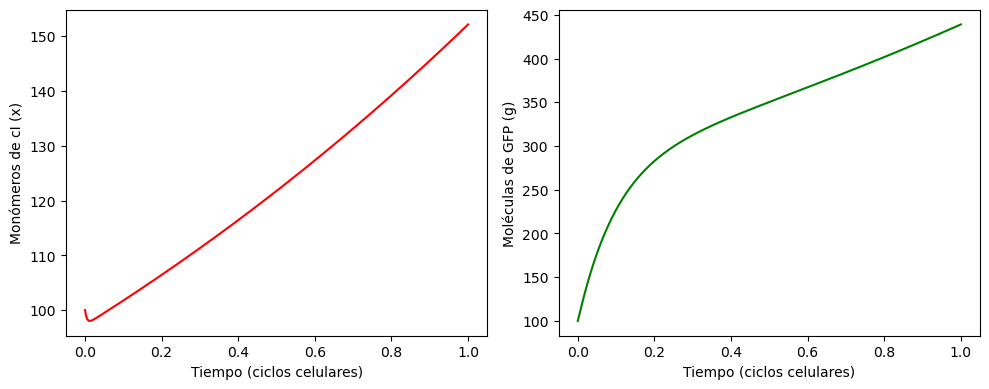

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Parámetros del modelo (Tabla 1 del artículo)
m = 60       # Número de copias del plásmido (ColE1)
α = 11       # Activación transcripcional (OR1+OR2)
σ1 = 2.0     # Afinidad de unión a OR2 (relativa a OR1)
σ2 = 0.08    # Afinidad de unión a OR3 (relativa a OR1)
β = 100.0    # Tasa basal de producción de cI
η = 0.01     # Eficiencia de producción de GFP vs. cI
γ_g = 10.0   # Tasa de degradación de GFP
c1 = 0.05    # Constante de dimerización de cI
c2 = 0.33    # Constante de unión cI-OR1
c = c1 * c2  # Combinación de constantes

# Condiciones iniciales
x0 = 100.0   # Monómeros de cI iniciales
g0 = 100.0   # Moléculas de GFP iniciales
v0 = 1.0     # Volumen celular inicial (adimensional)

def ode_system(state, t, γ_x, c1, c, m, γ_g, η, β, α, σ1, σ2):
    x, g = state
    v = v0 * np.exp(np.log(2) * t)  # Crecimiento exponencial del volumen
    
    # Cálculo de f(x, v) y h(x, v) (Ecs. 14 y 15 del artículo)
    denominator = 1 + (c*x**2)/v**2 + σ1*(c**2*x**4)/v**4 + σ1*σ2*(c**3*x**6)/v**6
    d0 = m / denominator  # Sitios operadores no unidos (Ec. 10)
    f = d0 * m * (1 + (c*x**2)/v**2 + α*σ1*(c**2*x**4)/v**4)  # Ec. 14
    
    h = 1 + (4*c1*x)/v + (4*c*x*d0)/v**2 + (16*σ1*c**2*x**3*d0)/v**4 + (36*σ1*σ2*c**3*x**5*d0)/v**6  # Ec. 15
    
    # Ecuaciones diferenciales (Ecs. 13 y 17)
    dxdt = (β * f - γ_x * x) / h
    dgdt = η * β * f - γ_g * g
    return [dxdt, dgdt]

# Tiempo de integración (1 ciclo celular)
t = np.linspace(0, 1, 1000)
γ_x = 3000  # Tasa de desestabilización de cI (ejemplo)

# Resolver las ODEs
solution = odeint(ode_system, [x0, g0], t, args=(γ_x, c1, c, m, γ_g, η, β, α, σ1, σ2))
x_sol, g_sol = solution[:, 0], solution[:, 1]

# Graficar resultados
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(t, x_sol, 'r')
plt.xlabel('Tiempo (ciclos celulares)')
plt.ylabel('Monómeros de cI (x)')

plt.subplot(1, 2, 2)
plt.plot(t, g_sol, 'g')
plt.xlabel('Tiempo (ciclos celulares)')
plt.ylabel('Moléculas de GFP (g)')
plt.tight_layout()
plt.show()

In [27]:
# Parámetros (usa siempre nombres ASCII)
m      = 60.0       # Plásmid copy number
alpha  = 11.0       # Transcriptional activation
sigma1 = 2.0        # OR2 binding affinity
sigma2 = 0.08       # OR3 binding affinity
beta   = 100.0      # Basal cI production
eta    = 0.01       # GFP production efficiency
gamma_g= 10.0       # GFP degradation rate   <-- aquí defines gamma_g
b0     = 4.0        # Fluorescence offset
c1     = 0.05       # Dimerization constant
c2     = 0.33       # cI-OR1 binding constant
c      = c1 * c2
x0     = 100.0      # Initial cI monomers
g0     = 100.0      # Initial GFP molecules
v0     = 1.0        # Initial cell volume
gamma_x_range = np.linspace(500, 15000, 20)


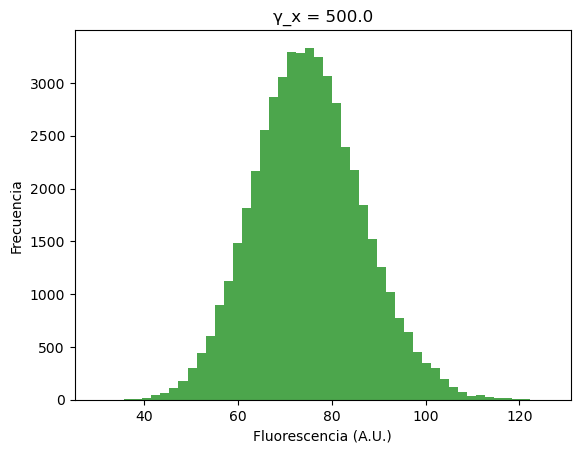

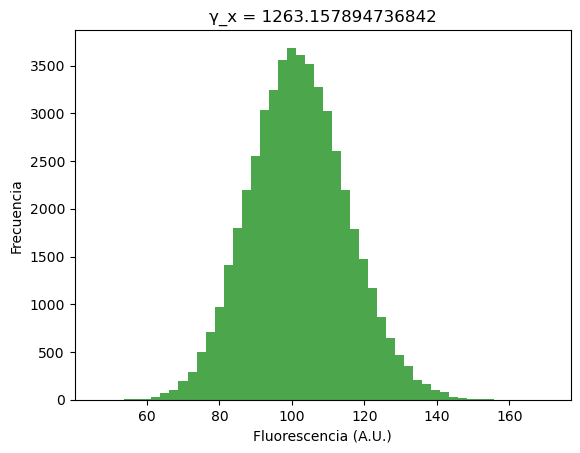

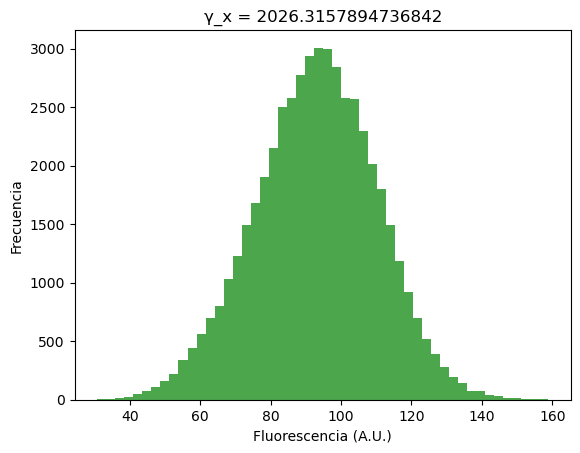

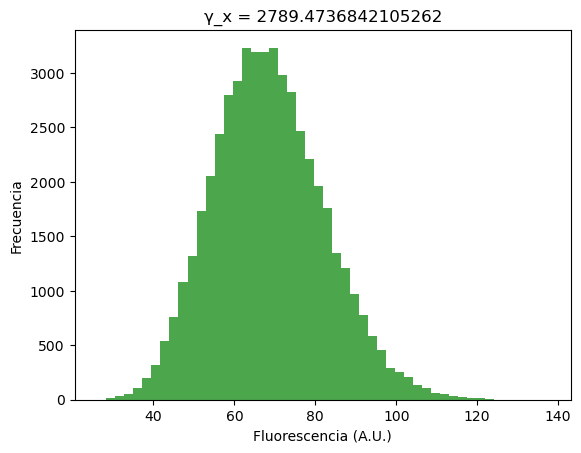

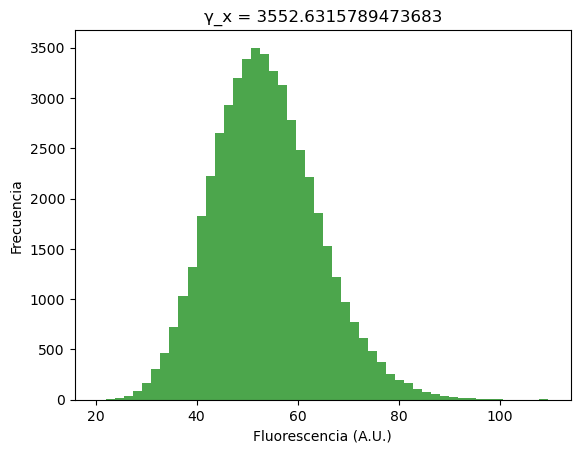

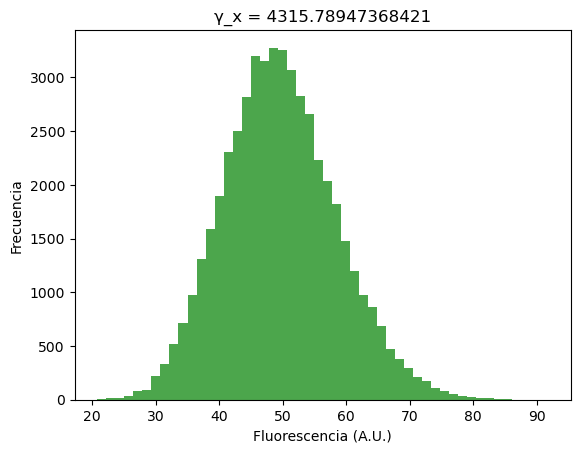

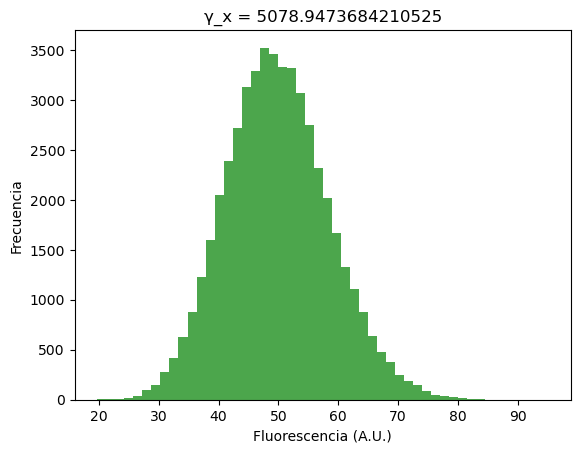

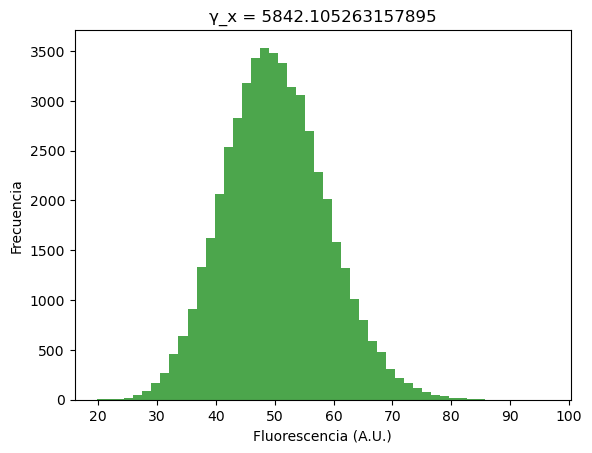

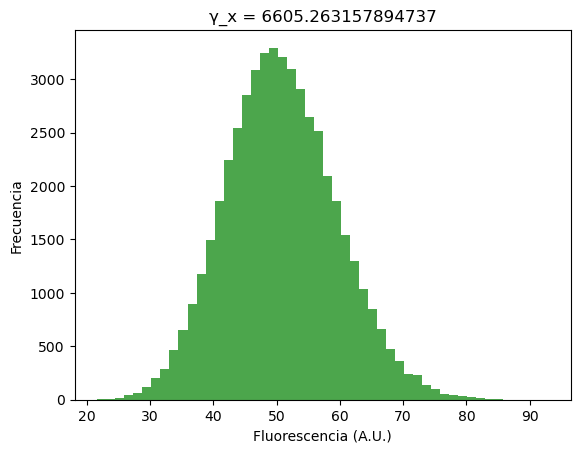

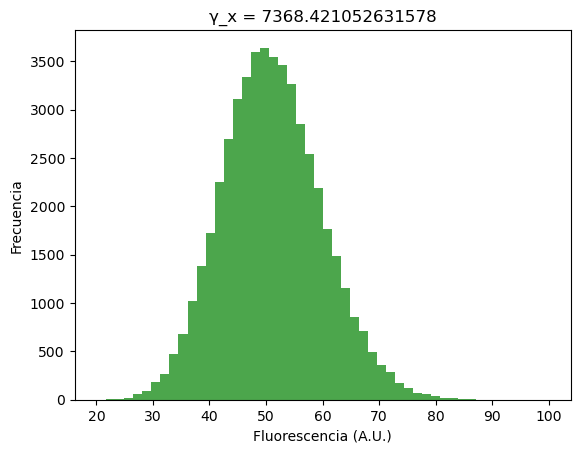

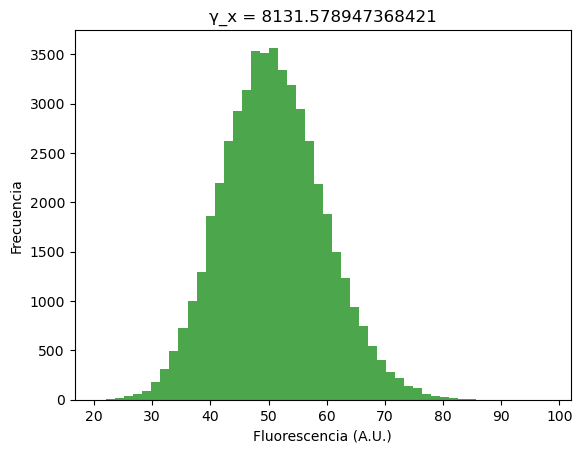

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def stochastic_simulation(gamma_x, c1, c, m, gamma_g, eta, beta, alpha,
                          sigma1, sigma2, x0, g0, v0, b0, num_cells=50000):
    x_final = np.zeros(num_cells)
    g_final = np.zeros(num_cells)

    dt = 0.01
    steps_per_cycle = int(1.0 / dt)
    total_steps = 10 * steps_per_cycle  # 10 ciclos celulares

    for i in range(num_cells):
        x, g, v = x0, g0, v0
        for step in range(1, total_steps + 1):
            # crecimiento continuo
            v *= np.exp(np.log(2) * dt)

            # cálculo de f, d0 y h
            denom = 1 + (c*x**2)/v**2 + sigma1*(c**2 * x**4)/v**4 + sigma1*sigma2*(c**3 * x**6)/v**6
            d0 = m / denom
            f = (1 + (c*x**2)/v**2 + alpha*sigma1*(c**2 * x**4)/v**4) * d0
            h = (1
                 + (4*c1*x)/v
                 + (4*c*x*d0)/v**2
                 + (16*sigma1*c**2 * x**3 * d0)/v**4
                 + (36*sigma1*sigma2*c**3 * x**5 * d0)/v**6)

            # derivadas
            dxdt = (beta * f - gamma_x * x) / h
            dgdt = eta * beta * f - gamma_g * g

            # amplitudes de ruido (clipped a ≥0)
            amp_x = np.sqrt(np.maximum((beta * f + gamma_x * x) / h, 0))
            amp_g = np.sqrt(np.maximum(eta * beta * f + gamma_g * g, 0))

            # Euler–Maruyama
            x += dxdt * dt + amp_x * np.sqrt(dt) * np.random.normal()
            g += dgdt * dt + amp_g * np.sqrt(dt) * np.random.normal()

            # evitar valores negativos
            x = max(x, 0.0)
            g = max(g, 0.0)

            # división celular cada ciclo
            if step % steps_per_cycle == 0:
                x /= 2
                g /= 2
                v /= 2

        x_final[i] = x
        g_final[i] = g

    # fluorescencia
    c_gamma = 4.0
    F = c_gamma * (g_final + b0)

    plt.hist(F, bins=50, color='green', alpha=0.7)
    plt.xlabel('Fluorescencia (A.U.)')
    plt.ylabel('Frecuencia')
    plt.title(f'γ_x = {gamma_x}')
    plt.show()


# Ahora sí barrido correcto sobre gamma_x_range:
for gamma_x in gamma_x_range:
    stochastic_simulation(
        gamma_x,
        c1, c, m,
        gamma_g, η, β, α,
        σ1, σ2,
        x0, g0, v0,
        b0
    )
